In [ ]:
import torch 
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable
from sklearn.neighbors import LocalOutlierFactor

import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def fix_seed():
    seed = 42
    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    numpy.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def load_preencoded_data(model_name, dataset_name,img_size,bs=64,shuffle=False,file_path=None):
    if file_path!= None:
      loaded = torch.load(file_path)
    else:
      loaded = torch.load('./data/'+dataset_name+'_'+model_name+'_'+str(img_size)+'.pt')
    trainset = torch.utils.data.TensorDataset(loaded['traindata'], loaded['trainlabel'])
    testset = torch.utils.data.TensorDataset(loaded['testdata'], loaded['label_test'])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=shuffle, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=shuffle, num_workers=0)
    return trainset, testset, trainloader, testloader

from torch.utils.data import Dataset

class SubDataset(Dataset):
    '''To sub-sample a dataset, taking only those samples with label in [sub_labels].
    After this selection of samples has been made, it is possible to transform the target-labels,
    which can be useful when doing continual learning with fixed number of output units.'''

    def __init__(self, original_dataset, sub_labels, target_transform=None,transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.sub_indeces = []
        for index in range(len(self.dataset)):
            if hasattr(original_dataset, "targets"):
                if self.dataset.target_transform is None:
                    label = self.dataset.targets[index]
                else:
                    label = self.dataset.target_transform(self.dataset.targets[index])
            else:
                label = self.dataset[index][1]
            if label in sub_labels:
                self.sub_indeces.append(index)
        self.target_transform = target_transform
        self.transform=transform

    def __len__(self):
        return len(self.sub_indeces)

    def __getitem__(self, index):
        sample = self.dataset[self.sub_indeces[index]]
        if self.transform:
            sample=self.transform(sample)
        if self.target_transform:
            target = self.target_transform(sample[1])
            sample = (sample[0], target)
        return sample
    
model_name = "vits8"
img_size=224

def compute_distances_gpu(X,Y):


    dists = torch.sqrt(-2 * torch.mm(X,Y.T) +
                    torch.sum(torch.pow(Y, 2),dim=1) +
                    torch.sum(torch.pow(X, 2),dim=1).view(-1,1))

    return dists

In [ ]:
# last one
class SONN(nn.Module):
    def __init__(self,Time_period, n_mini_batch,n_class=10,n_feat=384):
        super(SONN, self).__init__()
        self.n_feat=n_feat
        self.n_class=n_class
        self.Time_period = Time_period 
        self.ema = 2/(Time_period+1)
        self.n_mini_batch = n_mini_batch
        self.count=0
        self.T=1
        self.Address=torch.zeros(1,n_feat).to(device)
        self.M=torch.zeros(1,self.n_class)
        self.p_norm="fro"
        self.Error=torch.zeros(len(self.Address)).to(device)
        self.global_error=0
        self.Time_period_Temperature = self.ema
        self.ema_Temperature=(2/(self.Time_period_Temperature+1))
        self.memory_global_error=torch.zeros(1)
        self.memory_min_distance=torch.zeros(1)
        self.memory_count_address=torch.zeros(1)
        self.dataset_name="MNIST"
        
        self.acc_after_each_task=[]
        self.acc_aft_all_task=[]
        self.stock_feat=torch.tensor([]).to(device)
        self.forgetting=[]
        self.N_prune=5000
        self.prune_mode="balance"#naive,balance
        self.n_neighbors=20
        self.contamination="auto"
        self.pruning=False
        
        self.cum_acc_activ=False
        
        self.batch_test=True

        
        self.reset()
        
    def apply_param(self,T,pruning,N_prune,n_neighbors,Time_period_Temperature):
        self.T=T
        self.pruning=True
        self.N_prune=N_prune
        self.n_neighbors=n_neighbors
        self.Time_period_Temperature=Time_period_Temperature
        
    def reset(self):
        self.ema = 2/(self.Time_period+1)
        self.ema_Temperature=(2/(self.Time_period_Temperature+1))
        self.count=0
        self.Address=torch.zeros(1,self.n_feat).to(device)
        self.M=torch.zeros(1,self.n_class).to(device)
        self.Error=torch.zeros(len(self.Address)).to(device)
        self.global_error=0
        self.memory_global_error=torch.zeros(1)
        self.memory_min_distance=torch.zeros(1)
        self.memory_count_address=torch.zeros(1)
        
    def forward(self,inputs):
        with torch.no_grad():
            out = inputs
#             out = self.encoder(inputs.to(device))
            pred=torch.tensor([]).to(device)
            if self.batch_test:
                distance=compute_distances_gpu(inputs,self.Address)
                soft_norm = F.softmin(distance/self.T,dim=-1)
                pred = torch.matmul(soft_norm, self.M)
            else:
                for idx_x in range(len(out)):
                    x=out[idx_x]
                    distance=x-self.Address
                    norm=torch.norm(distance, p=self.p_norm, dim=-1)
                    # softmin vs argmin
                    soft_norm = F.softmin(norm/self.T,dim=-1)
                    soft_pred = torch.matmul(soft_norm, self.M.to(device)).view(-1)
                    pred=torch.cat((pred,soft_pred.view(1,-1)),0)

        return pred   
    
    def prune(self):
        N_pruning=self.N_prune
        n_class = self.M.size(1)
        if len(self.Address)>N_pruning:
            clf = LocalOutlierFactor(n_neighbors=min(len(self.Address),self.n_neighbors), contamination=self.contamination)
            A=self.Address
            M=self.M
            y_pred = clf.fit_predict(A.cpu())#>0 inliner
            X_scores = clf.negative_outlier_factor_
            x_scor=torch.tensor(X_scores)
            if self.prune_mode=="naive":
                if len(A)>N_pruning:
                    prun_N_addr=len(A)-N_pruning
                    val,ind=torch.topk(x_scor,prun_N_addr)
                    idx_remove=[True]*len(A)
                    for i in ind:
                        idx_remove[i] = False
                    self.M=self.M[idx_remove]
                    self.Address=self.Address[idx_remove]

            if self.prune_mode=="balance":
                prun_N_addr=len(A)-N_pruning
                mean_addr=N_pruning//n_class
                val, ind = torch.sort(x_scor, descending=True)

                count=prun_N_addr
                idx_remove=[True]*len(A)
                idx=0
                arg_m=torch.argmax(M,axis=1)
                N_remaining=torch.bincount(arg_m)
                while count!=0:
                    
                    idx+=1
                    indice=ind[idx]
                    if N_remaining[arg_m[indice]]>(N_pruning//n_class):
                        N_remaining[arg_m[indice]]-=1
                        idx_remove[ind[idx]] = False

                        count-=1

                self.M=self.M[idx_remove]
                self.Address=self.Address[idx_remove]
                
#             if self.prune_mode == 'k_means':
#                 prun_N_addr=len(A)-N_pruning
#                 mean_addr=N_pruning//n_class

#                 count=prun_N_addr
#                 idx_remove=[True]*len(A)
#                 idx=0
#                 arg_m=torch.argmax(M,axis=1)
#                 N_remaining=torch.bincount(arg_m)
                
#                 kmeans = sklearn.cluster.KMeans(n_clusters=, ).fit(x_train)
#                 centroids = kmeans.cluster_centers_
        
    def test(self,testloader):
        total=0
        correct=0
        for batch_idx, (inputs, targets) in enumerate(testloader):
            targets=targets.type(torch.LongTensor).to(device)
            inputs=inputs.to(device)
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs,1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        accuracy=correct/total*100
        print(" test accuracy {:.3f} %,  {:.3f} / {:.3f} ".format(accuracy, correct,total))
        return accuracy
    
    def test_idx(self,test_dataset_10_way_split,idx_test):
        with torch.no_grad():
            total=0
            correct=0

            for idx in idx_test:
                curr_correct=0
                curr_total=0
                for batch_idx, (inputs, targets) in enumerate(test_dataset_10_way_split[idx]):
                    inputs=inputs.to(device)
                    targets=targets.type(torch.LongTensor).to(device)
                    outputs = self.forward(inputs)
                    _, predicted = torch.max(outputs,1)
                    total += targets.size(0)
                    corr=(predicted == targets).sum().item()
                    curr_correct +=corr
                    correct += corr
                    curr_total+=targets.size(0)
            accuracy=correct/total*100
#         print(" test accuracy {:.3f} %,  {:.3f} / {:.3f} ".format(accuracy, correct,total))
        return accuracy,curr_correct/curr_total*100
    
    def train__test_n_way_split(self, train_dataset_10_way_split, test_dataset_10_way_split,coef_global_error=1,ema_global_error=None, plot=True, save_feat=False): # n equal len train_dataset_10_way_split
        flag=False
        acc_test=torch.zeros(len(train_dataset_10_way_split))
        acc_test_after_each_task_softmin = torch.zeros(len(train_dataset_10_way_split))
        self.memory_min_distance=torch.zeros(1)
        idx_seen=[]
        self.cum_acc=[]
        with torch.no_grad():
            for idx_loader in range(len(train_dataset_10_way_split)):
                idx_seen.append(idx_loader)
                #train loop
                for batch_idx, (inputs, targets) in enumerate(train_dataset_10_way_split[idx_loader]):
                    inputs=inputs.to(device)
                    targets=targets.type(torch.LongTensor).to(device)
                    if batch_idx==self.n_mini_batch:
                        break
                    if save_feat:
                        self.stock_feat=torch.cat((self.stock_feat,inputs))
                    for idx_x in range(len(inputs)):
                        out=inputs#.to(device)
                        x=out[idx_x]
                        self.count+=1
                        distance=x-self.Address
                        norm=torch.norm(distance, p=self.p_norm, dim=-1)
                        soft_norm=norm

                        max_value, idx_max=torch.min(norm,0)

                        self.global_error+= self.ema_Temperature*(max_value-self.global_error)
#                         self.memory_global_error=torch.cat((self.memory_global_error,torch.tensor([self.global_error])))
#                         smoth_min_dist= self.memory_min_distance[-1] + (max_value-self.memory_min_distance[-1])*2/(1+20)
#                         self.memory_min_distance=torch.cat((self.memory_min_distance,torch.tensor([smoth_min_dist])))

    #                     max_value, idx_max=torch.max(out,0)
                        if abs(norm[idx_max])>=self.global_error*coef_global_error:
                            # create a new address
                            self.Address=torch.cat((self.Address,x.view(1,-1)))
#                             self.Error=torch.cat((self.Error,torch.ones(1).to(device)))
                            targets_one_hot=F.one_hot(targets[idx_x], num_classes=self.n_class).float()
                            self.M=torch.cat((self.M,targets_one_hot.view(1,-1)))
                        else: #SOM like
                            delta_address = distance
                            soft_norm = F.softmin(norm/self.T,dim=-1)
                            

                            self.Address = self.Address + self.ema * torch.mul(soft_norm.view(-1,1),delta_address)
                            targets_one_hot=F.one_hot(targets[idx_x], num_classes=self.n_class).float()

                            self.M += self.ema * torch.mul(soft_norm.view(-1,1),(targets_one_hot-self.M))   #(self.M[idx_max]-targets_one_hot)
#                             self.Error[idx_max] += self.ema*(norm[idx_max] - self.Error[idx_max])
#                             self.memory_count_address=torch.cat((self.memory_count_address,torch.tensor([self.M.size(0)])))
                if self.pruning:
#                     print(len(self.Address))
                    self.prune()
#                     print(len(self.Address))
                if self.cum_acc_activ:
                    acc,last_acc = self.test_idx(test_dataset_10_way_split,idx_seen)
                    self.cum_acc.append(acc)
                    acc_test_after_each_task_softmin[idx_loader] = last_acc

#                 if self.batch_test:
#                     count_input=0
#                     correct=0
#                     correct_softmin=0
#                     if False:
#                         for batch_idx, (inputs, targets) in enumerate(test_dataset_10_way_split[idx_loader]):

#                             out=inputs.to(device)
#                             targets=targets.type(torch.LongTensor)
#                             for i in range(len(out)):
#                                 count_input += 1
#                                 x=out[i]
#                                 distance=x-self.Address
#                                 norm=torch.norm(distance, p=self.p_norm, dim=-1)
#                                 # softmin vs argmin
#                                 soft_norm = F.softmin(norm/self.T,dim=-1)
#                                 soft_pred = torch.matmul(soft_norm, self.M.to(device)).view(-1)
#                                 arg_soft_pred = torch.argmax(soft_pred)
#                                 #argmin
#                                 idx=torch.argmin(norm)
#                                 pred = torch.argmax(self.M[idx])
#                                 if pred==targets[i]:
#                                     correct += 1
#                                 if arg_soft_pred==targets[i]:
#                                     correct_softmin += 1
#                         acc_test[idx_loader] = correct/count_input
#                         acc_test_after_each_task_softmin[idx_loader] = correct_softmin/count_input
#             print(acc_test_after_each_task_softmin)
            
#             acc_test_just_after_learn_1_task=acc_test*100
            
            self.acc_after_each_task=acc_test_after_each_task_softmin
            acc_test_after_each_task_softmin=acc_test_after_each_task_softmin
            
            acc_test_after_all_task_softmin=torch.zeros(len(train_dataset_10_way_split))
            acc_test=torch.zeros(len(train_dataset_10_way_split))
#             if self.pruning:
#                 self.prune()
            # test after learn all task
            
            for idx_loader in range(len(test_dataset_10_way_split)):#len(train_stl_10_way_split)
                count_input=0
                correct=0
                correct_softmin=0
                if self.batch_test:
                    acc,last_acc = self.test_idx(test_dataset_10_way_split,[idx_loader])
                    acc_test[idx_loader]=0 #pas calculer
                    acc_test_after_all_task_softmin[idx_loader]=last_acc
                else:
                    for batch_idx, (inputs, targets) in enumerate(test_dataset_10_way_split[idx_loader]):
                        out=inputs.to(device)
                        targets=targets.type(torch.LongTensor)
                        for i in range(len(out)):
                            count_input += 1
                            x=out[i]
                            distance=x-self.Address
                            norm=torch.norm(distance, p=self.p_norm, dim=-1)
                            #softmin
                            soft_norm=F.softmin(norm/self.T,dim=-1)
                            soft_pred = torch.matmul(soft_norm, self.M.to(device)).view(-1)
                            arg_soft_pred = torch.argmax(soft_pred)
                            #argmin
                            idx=torch.argmin(norm)
                            pred = torch.argmax(self.M[idx])
                            if pred==targets[i]:
                                correct += 1
                            if arg_soft_pred==targets[i]:
                                correct_softmin += 1
                    acc_test[idx_loader]=correct/count_input*100
                    acc_test_after_all_task_softmin[idx_loader]=correct_softmin/count_input*100
                


                self.acc_aft_all_task=acc_test_after_all_task_softmin
#                 print(acc_test[idx_loader])
#             print(acc_test)
            if plot :#and acc_test.mean().item()>80:
                plt.figure(figsize=(15,10))
                plt.plot(acc_test)
                plt.plot(acc_test_just_after_learn_1_task)
                plt.plot(acc_test_after_all_task_softmin)
#                 plt.plot(acc_test_after_each_task_softmin)
                plt.legend(["after learn all task","after learn each task","after learn all task with softmin"])
                plt.title("accuracy on all task = {:.2f} %".format(acc_test.mean().item())+"same accuracy with softmin (with T= {:.2f}) =".format(self.T)+"{:.3f}".format(acc_test_after_all_task_softmin.mean().item())+" on 10 way split cifar 10,\n Time_period = "+ str(Time_period)+ " number of data per class = "+str(self.n_mini_batch*bs)+" address use "+str(self.M.size(0)))  
                plt.ylabel("test accuracy %")
                plt.xlabel("task 0 to task 9")
                for i in range(0,self.n_class):
                    plt.vlines(i,min(acc_test),100,colors='k', linestyles='dotted', label='end task 0')
                plt.show()
                plt.figure(figsize=(15,10))
                n_taskss=(np.linspace(0,len(test_dataset_10_way_split),len(self.memory_global_error)))
                plt.plot(n_taskss,self.memory_global_error)
                n_taskss=(np.linspace(0,len(test_dataset_10_way_split),len(self.memory_min_distance)))
                plt.plot(n_taskss,self.memory_min_distance, alpha=0.3)
                n_taskss=(np.linspace(0,len(test_dataset_10_way_split),len(self.memory_count_address)))
                plt.plot(n_taskss,self.memory_count_address/max(self.memory_count_address)*100)
                for i in range(1,len(test_dataset_10_way_split)+1):
                    plt.vlines(i,0,70,colors='k', linestyles='dotted', label='end task 0')
                plt.show()
            return acc_test_after_each_task_softmin, acc_test_after_all_task_softmin
        
    def grid_search_spread_factor(self, Time_period, n_mini_batch, train_dataset_10_way_split, test_dataset_10_way_split,N_try=5,ema_global_error="same",coef_global_error=1,plot=True,random_ordering=True):
        flag=False
        acc_test=torch.zeros(N_try,len(train_dataset_10_way_split))
        accuracy_std_test=torch.zeros(len(train_dataset_10_way_split))
        accuracy_mean_test=torch.zeros(len(train_dataset_10_way_split))
        
        cum_acc=torch.zeros(N_try,len(train_dataset_10_way_split))
        
        acc_test_softmin=torch.zeros(N_try,len(train_dataset_10_way_split))
        accuracy_mean_test_softmin=torch.zeros(len(train_dataset_10_way_split))
        accuracy_std_test_softmin=torch.zeros(len(train_dataset_10_way_split))
        N_address_use=torch.zeros(N_try)
        self.forgetting=[]
        
        self.n_mini_batch=n_mini_batch
        self.Time_period = Time_period 
        self.ema = 2/(Time_period+1)
        for idx_try in tqdm(range(N_try)):
            self.reset()
            Acc_test, Acc_test_softmin = self.train__test_n_way_split(train_dataset_10_way_split, test_dataset_10_way_split,ema_global_error=ema_global_error,plot=False,coef_global_error=coef_global_error)
            if self.cum_acc_activ:
                cum_acc[idx_try]=torch.tensor(self.cum_acc)
            self.forgetting.append((self.acc_after_each_task*100-self.acc_aft_all_task).mean())
            acc_test[idx_try]=Acc_test
            acc_test_softmin[idx_try]=Acc_test_softmin
            N_address_use[idx_try] = self.M.size(0)
            #random ordering
            if random_ordering:
                dataset_shuffle = list(zip(train_dataset_10_way_split, test_dataset_10_way_split))
                random.shuffle(dataset_shuffle)
                train_dataset_10_way_split, test_dataset_10_way_split = zip(*dataset_shuffle)

        accuracy_mean_test=acc_test.mean(0)
        accuracy_std_test=acc_test.std(0)
        accuracy_mean_test_softmin = acc_test_softmin.mean(0)
        acc_soft_mean=acc_test_softmin.mean(1)
        
        accuracy_std_test_softmin = acc_test_softmin.std(0)
        print("forgetting softmin inference = {:.1f} % ± {:.1f}".format(np.mean(self.forgetting),np.std(self.forgetting)))

#         plt.plot(accuracy_mean_test_softmin)
#         plt.fill_between(np.linspace(0,len(accuracy_mean_test_softmin)-1,len(accuracy_mean_test_softmin)), accuracy_mean_test_softmin-accuracy_std_test_softmin, accuracy_mean_test_softmin+accuracy_std_test_softmin, alpha = 0.5)
        if plot:
            plt.errorbar(np.linspace(1,len(accuracy_mean_test_softmin),len(accuracy_mean_test_softmin)),accuracy_mean_test_softmin,accuracy_std_test_softmin,linestyle='None', fmt='o',capsize = 5)
    #         plt.plot(accuracy_mean_test)
    #         plt.fill_between(np.linspace(0,len(accuracy_mean_test)-1,len(accuracy_mean_test)), accuracy_mean_test-accuracy_std_test, accuracy_mean_test+accuracy_std_test, alpha = 0.5)
            print(str(len(train_dataset_10_way_split))+"-way split, MNIST test accuracy on all task = {:.1f} % ± {:.1f}, mean Address use =  {:.1f} ".format(acc_soft_mean.mean().item(), acc_soft_mean.std().item(),N_address_use.mean()))#
            print(["accuracy softmin T_softmin = {:.1f} ".format(self.T)])
            plt.xlabel("task 1 to task "+str(len(train_dataset_10_way_split)))
            plt.ylabel("Test Accuracy")
            plt.ylim(bottom=40)
            plt.savefig("DSDM MNIST.pdf")

            plt.show()
#         y2=forgetting
#         y3=N_address_use
#         label_x  = "spread factor"
#         label_y1 = "accuracy on "+str(len(train_dataset_10_way_split))+ " tasks"
#         label_y2 = "forgetting"
#         label_y3 = "number of neurons used" 
#         title=("10 way split cifar 10, Time_period = "+ str(Time_period)+ " number of data per class = "+str(self.n_mini_batch*bs))
        return acc_soft_mean,N_address_use.mean(),acc_test,cum_acc



Mounted at /content/drive


In [ ]:
img_size=224
model_name="resnet18"
dataset_name="Core50"

In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1Yo7VJ93VGWQo070QHKB_6mG76iNDrVvT

In [ ]:
# enter YOUR file path

#  from google.colab import drive
#  drive.mount('/content/drive')
file_path= "/content/Core50_resnet18_224.pt" #"/content/drive/MyDrive/DSDM/Core50_resnet18_224.pt" 

trainset, testset, trainloader, testloader=load_preencoded_data(model_name, dataset_name,img_size,file_path=file_path)

bs=50

train_set, val_set = torch.utils.data.random_split(trainset, [25000, len(trainset)-25000])


train_cifar100_100_way_split=[]
val_cifar100_100_way_split=[]

test_cifar100_100_way_split=[]
i=0
train_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(train_set,[i,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9]), batch_size=bs,
                                      shuffle=True, num_workers=0))
val_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(val_set,[i,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9]), batch_size=bs,
                                      shuffle=False, num_workers=0))
test_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(testset,[i,i+1,i+2,i+3,i+4,i+5,i+6,i+7,i+8,i+9]), batch_size=bs,
                                      shuffle=False, num_workers=0))
for i in range(10,50,5):
    train_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(train_set,[i,i+1,i+2,i+3,i+4]), batch_size=bs,
                                          shuffle=True, num_workers=0))
    val_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(val_set,[i,i+1,i+2,i+3,i+4]), batch_size=bs,
                                          shuffle=False, num_workers=0))
    test_cifar100_100_way_split.append(torch.utils.data.DataLoader(SubDataset(testset,[i,i+1,i+2,i+3,i+4]), batch_size=bs,
                                          shuffle=False, num_workers=0))

100%|██████████| 5/5 [01:27<00:00, 17.53s/it]


forgetting softmin inference = 4231.6 % ± 332.6
9-way split, MNIST test accuracy on all task = 42.7 % ± 2.1, mean Address use =  1000.0 
['accuracy softmin T_softmin = 2.3 ']


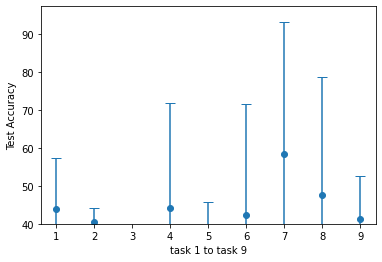

tensor(43.2465)
tensor(42.6616) 1000


100%|██████████| 5/5 [01:36<00:00, 19.34s/it]

forgetting softmin inference = 5006.4 % ± 318.3
9-way split, MNIST test accuracy on all task = 50.0 % ± 1.2, mean Address use =  2000.0 
['accuracy softmin T_softmin = 2.3 ']


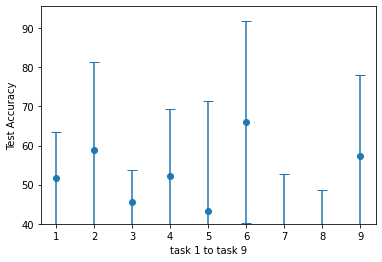

tensor(54.5471)
tensor(50.0382) 2000


100%|██████████| 5/5 [02:23<00:00, 28.61s/it]

forgetting softmin inference = 6455.4 % ± 106.7
9-way split, MNIST test accuracy on all task = 56.2 % ± 0.9, mean Address use =  5000.0 
['accuracy softmin T_softmin = 2.3 ']


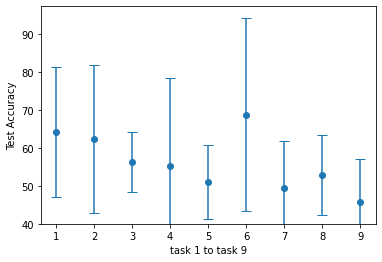

tensor(66.6657)
tensor(56.1940) 5000


100%|██████████| 5/5 [02:28<00:00, 29.79s/it]

forgetting softmin inference = 7149.8 % ± 154.6
9-way split, MNIST test accuracy on all task = 66.9 % ± 0.8, mean Address use =  10000.0 
['accuracy softmin T_softmin = 2.3 ']


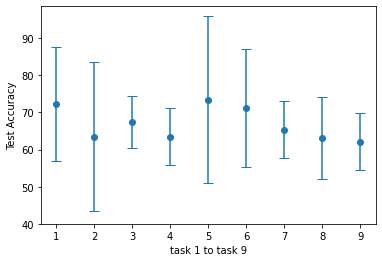

tensor(69.2211)
tensor(66.8754) 10000


In [ ]:
nprune=[1000,2000,5000,10000]
for i in nprune:
    N_try=5
#     n_mini_batch = trial.suggest_int("n_mini_batch", 30, 50)
    n_mini_batch=55

    alpha = 1#trial.suggest_uniform("alpha", 1.,1.2)
    Time_period = 500
    Time_period_temperature = 150
    sonn=SONN(Time_period ,n_mini_batch,50,n_feat=512)
    sonn.n_neighbors=1000
    sonn.contamination="auto"#trial.suggest_uniform("contamination", 0.1,0.5)
    sonn.p_norm="fro"
    sonn.T=2.3
    sonn.pruning=True
    sonn.N_prune=i
    sonn.cum_acc_activ=True
#     sonn.ema_content=2/(1+trial.suggest_int("ema content", 5, 500))
    sonn.Time_period_Temperature = Time_period_temperature
    accuracy_c100_100w,N_address_use_c100_100w,acc_test_softmin,cum_sum = sonn.grid_search_spread_factor(Time_period, n_mini_batch, train_cifar100_100_way_split,test_cifar100_100_way_split,N_try,ema_global_error="diff",coef_global_error=alpha)
    metric=accuracy_c100_100w.mean()#-accuracy_c100_100w.std()
    print(cum_sum.mean())
    print(metric,len(sonn.Address))#, sonn.test(testloader))